<a href="https://colab.research.google.com/github/henriquevedoveli/TCC/blob/main/notebooks/models/tccAlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Treinameto e Avaliação do Modelo _AlexNet_**

---

## **Classificação de Pneumonia em Radiografia do Tórax Utilizando Redes Neurais Convolucionais**

---

#### Autor: Henrique Hundsdorfer Vedoveli

#### Orientador: Prof. Dr. Anuar José Mincache

#### Coorientador: Prof. Dr. Breno Ferraz de Oliveira

---
# Bibliotecas Necessárias
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import *
 
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
 
# keras models
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping#

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image  
 
########################################################################################
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

np.random.seed(7)
 
import os
 
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## Local onde as imagens estão armazenadas
---

In [ ]:
TRAIN = '/content/drive/MyDrive/TCC/data/chest_xray/train'
TEST = '/content/drive/MyDrive/TCC/data/chest_xray/test'
VAL = '/content/drive/MyDrive/TCC/data/chest_xray/val'

MODELS = '/content/drive/MyDrive/TCC/MODELS'

---

# Carregando as imagens e aplicando o _data augmentation_

----

## Parâmetros utilizados para o _data augmentation_

|                        Distorção                       |  Parâmetro |
|:------------------------------------------------------:|:----------:|
|           Alteração na Escala _(Zoom Range)_           | 0.9 a 1,25 |
|           Faixa de Rotação _(Rotation Range)_          |     10°    |
| Faixa de Deslocamento Horizontal _(Width Shift Range)_ |     0.1    |
|  Faixa de Deslocamento Vertical _(Height Shift Range)_ |     0.1    |
|           Modo de Preenchimento _(Fill Mode)_          |  Constante |
|                          Cval                          |      0     |

In [ ]:
trainData = ImageDataGenerator(zoom_range = [0.9, 1.25], 
                                        rotation_range = 10,
                                        vertical_flip = True,
                                        horizontal_flip = False, 
                                        width_shift_range = 0.1, 
                                        height_shift_range = 0.1,
                                        fill_mode='constant', 
                                        cval=0)

trainData = trainData.flow_from_directory(directory=TRAIN,
                                       batch_size = 32,
                                       target_size=(224,224),
                                       color_mode = 'grayscale',
                                      )

valData = ImageDataGenerator()
valData = valData.flow_from_directory(
        VAL,
        target_size = (224,224),
        batch_size = 32,
        color_mode = 'grayscale'
        )

testData = ImageDataGenerator()
testData = testData.flow_from_directory(directory=TEST,
                                      batch_size = 32,
                                      target_size=(224,224),
                                      color_mode = 'grayscale')

---
# Encontrando os pesos de cada classe.
---

In [ ]:
normalLength = len(os.listdir(TRAIN + '/' + 'NORMAL'))
bacterialLength = len(os.listdir(TRAIN + '/' + 'BACTERIAL'))
viralLength = len(os.listdir(TRAIN + '/' + 'VIRAL'))
dataLength = normalLength + bacterialLength +  viralLength

print('Qtd dados de treino: ', dataLength)
print('Qtd dados de pulmão saudavel para treino: ', normalLength)
print('Qtd dados Bacterial', bacterialLength)
print('Qtd dados Viral', viralLength)

class_weight = {0: 1., # bacterial
                1: bacterialLength / normalLength, #normal 
                2: bacterialLength / viralLength} # viral 

Qtd dados de treino:  5082
Qtd dados de pulmão saudavel para treino:  1299
Qtd dados Bacterial 2488
Qtd dados Viral 1295


In [ ]:
def generateImages(paths):
    '''
    params: paths ->
    '''
    test_images=[]
    interpret= trainData.class_indices
    test_y=[]
    
    for path in paths:
        y=''
        if 'NORMAL' in path:
            y='NORMAL'
        elif 'VIRAL' in path:   
            y='VIRAL'
        elif 'BACTERIAL' in path:   
            y='BACTERIAL'   
        
        for image_path in os.listdir(path):
            new_path=os.path.join(TEST, y)
            new_path=os.path.join(new_path,image_path)

            temp_images=image.load_img(new_path,
                                       color_mode = 'grayscale',
                                       target_size=(224,224)) 
            temp_images=image.img_to_array(temp_images)
            test_images.append(temp_images)
            test_y.append(interpret[y])

    return test_images,test_y

In [ ]:
def convertData(model, path, prob = 0):
    '''
    params: model ->
            path ->
            prob ->
    '''
    all_paths=[]
    print("• GERANDO PATHS")

    for directory in os.listdir(path):
        all_paths.append(os.path.join(path,directory))
    
    test_images, test_y= generateImages(all_paths)

    test_images=np.array(test_images)

    print("• GERANDO PREVISÕES")
    if prob == 0:
        predictions = np.argmax(model.predict(test_images), axis=1)
    else:
        predictions = model.predict_on_batch(test_images)

    print("ACURACIA DO MODELO PARA OS DADOS DE TESTE: {}".format( metrics.accuracy_score(test_y, predictions)))

    return test_y, predictions, test_images

---
# Definindo o Modelo
---

In [ ]:
units = 840
lr = 1e-5

modelAlex = Sequential()

modelAlex.add(Conv2D(filters=96, kernel_size = (11,11), activation='relu', input_shape=(224, 224, 1)))
modelAlex.add(MaxPooling2D(3,3))

modelAlex.add(Conv2D(filters=256, kernel_size = (5,5), activation='relu'))
modelAlex.add(MaxPooling2D(3,3))

modelAlex.add(Conv2D(filters=384, kernel_size = (3,3), activation='relu'))
modelAlex.add(Conv2D(filters=384, kernel_size = (3,3), activation='relu'))
modelAlex.add(Conv2D(filters=256, kernel_size = (3,3), activation='relu'))
modelAlex.add(MaxPooling2D(3,3))

modelAlex.add(Flatten())

modelAlex.add(Dense(units=units, activation='relu'))
modelAlex.add(Dense(units=units, activation='relu'))
modelAlex.add(Dense(units=3, activation='softmax'))

modelAlex.compile(loss='categorical_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=lr),
                     metrics = ['accuracy'])

In [ ]:
modelAlex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 214, 96)      11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 384)       1

---
# Otimização do Modelo
---


In [ ]:
hist = modelAlex.fit_generator(steps_per_epoch= trainData.n//32,
                           generator=trainData, 
                           validation_data= valData,
                           validation_steps=valData.n//32,
                           epochs=25,
                           class_weight = class_weight)

In [ ]:
temp = pd.DataFrame([hist.history['accuracy'], hist.history['val_accuracy'], hist.history['loss'], hist.history['val_loss']])

histT = temp.T
histT.columns = ['acc', 'val_acc', 'loss', 'val_loss']

from google.colab import files
numEpoch = 25
histT.to_csv(f'histTreinoALEXNET{numEpoch}.csv')
files.download(f'histTreinoALEXNET{numEpoch}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
temp = pd.DataFrame([hist.history['accuracy'], hist.history['val_accuracy'], hist.history['loss'], hist.history['val_loss']])

tempT = temp.T
tempT.columns = ['acc', 'val_acc', 'loss', 'val_loss']

histTreinoatg = pd.read_csv('histTreinoALEXNET75.csv')
histTreinoatg = histTreinoatg[['acc', 'val_acc', 'loss', 'val_loss']]
histT = histTreinoatg.append(tempT)
histT = histT.reset_index(drop=True)

from google.colab import files
numEpoch = 100
histT.to_csv(f'histTreinoALEXNET{numEpoch}.csv')
files.download(f'histTreinoALEXNET{numEpoch}.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[]

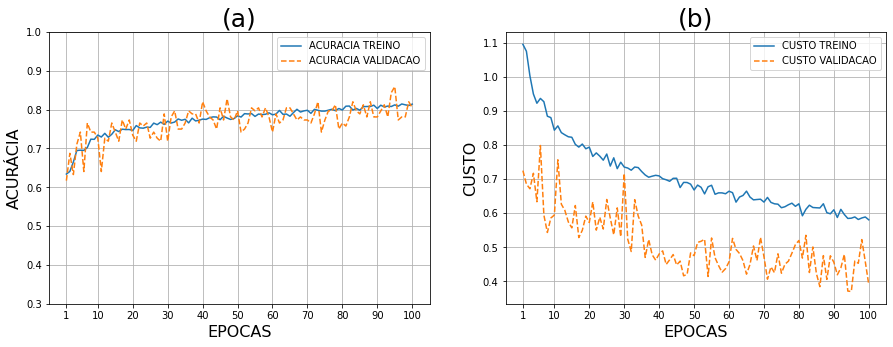

In [ ]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

axs[0].plot(histT.index + 1, histT['acc'])
axs[0].plot(histT.index + 1, histT['val_acc'], '--')
axs[0].set_title('(a)', size = 25)
axs[0].set_xlabel("EPOCAS", size = 16)
axs[0].set_ylabel("ACURÁCIA", size =16)
axs[0].set_yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
axs[0].set_xticks([1,10,20,30,40,50,60,70,80,90,100])
axs[0].legend(['ACURACIA TREINO', 'ACURACIA VALIDACAO'])
axs[0].grid(True)

axs[1].plot(histT.index + 1, histT['loss'])
axs[1].plot(histT.index + 1, histT['val_loss'], '--')
axs[1].set_title('(b)', size = 25)
axs[1].set_xlabel("EPOCAS", size =16)
axs[1].set_ylabel("CUSTO", size =16)
axs[1].legend(['CUSTO TREINO', 'CUSTO VALIDACAO'])
axs[1].set_xticks([1,10,20,30,40,50,60,70,80,90,100])
axs[1].grid(True)

plt.plot()

---
# Salvando o Modelo
---

In [ ]:
modelAlex.save('/content/drive/MyDrive/TCC/MODELS/ALEXNETMODEL')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/MODELS/ALEXNETMODEL/assets


In [ ]:
# modelAlex = keras.models.load_model('/content/drive/MyDrive/TCC/MODELS/ALEXNETMODEL')

---
# Avaliação do Modelo
---

• GERANDO PATHS
• GERANDO PREVISÕES
ACURACIA DO MODELO PARA OS DADOS DE TESTE: 0.8701923076923077


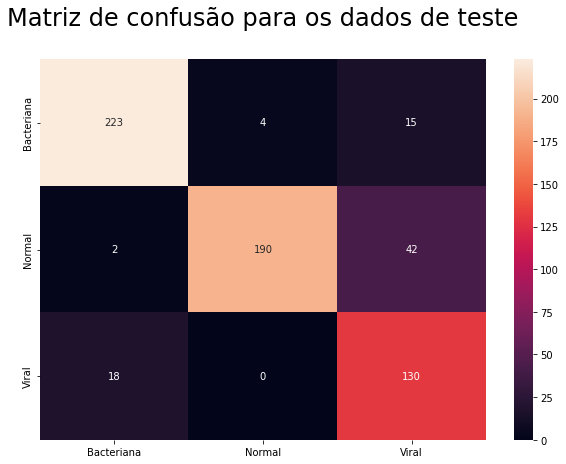

In [ ]:
test_y, pred, test_images = convertData(modelAlex, TEST, 0)

matrix = metrics.confusion_matrix(test_y, pred)

labels = ['Bacteriana' , 'Normal', 'Viral']

df_cm = pd.DataFrame(matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])

df_cm.index = labels
df_cm.columns = labels

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g')
ax.set_title("Matriz de confusão para os dados de teste\n", size = 24)
ax

In [ ]:
f1 = f1_score(test_y, pred, average= None)
recall = recall_score(test_y, pred, average= None)
precision = precision_score(test_y, pred, average= None)

metricas = pd.DataFrame([recall, precision, f1], columns=['Bacteriana' , 'Normal', 'Viral'], index = ['Recall', 'Precision','F1-Score']).T
metricas

,Recall,Precision,F1-Score
Bacteriana,0.921,0.918,0.920
Normal,0.812,0.979,0.888
Viral,0.878,0.695,0.776


In [ ]:
testBin = test_y
predBin = pred

i = 0
while i < len(pred):
    if predBin[i] == 0:
        predBin[i] = 3
    elif predBin[i] == 2:
        predBin[i] = 3

    i += 1

k = 0
while k < len(test_y):
    if testBin[k] == 0:
        testBin[k] = 3
    elif testBin[k] == 2:
        testBin[k] = 3

    k += 1

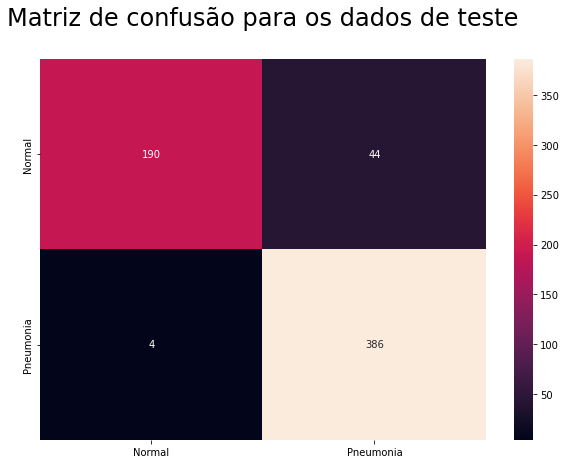

In [ ]:
matrix = metrics.confusion_matrix(testBin, predBin)

labels = ['Normal' , 'Pneumonia']

df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])

df_cm.index = labels
df_cm.columns = labels

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g')
ax.set_title("Matriz de confusão para os dados de teste\n", size = 24)
ax

In [ ]:
f1 = f1_score(testBin, predBin, average= None)
recall = recall_score(testBin, predBin, average= None)
precision = precision_score(testBin, predBin, average= None)
acc = accuracy_score(testBin, predBin)

print('ACC:', acc)

metricas = pd.DataFrame([recall, precision, f1], columns=['Normal' , 'Pneumonia'], index = ['Recall', 'Precision','F1-Score']).T
metricas


ACC: 0.9230769230769231


,Recall,Precision,F1-Score
Normal,0.812,0.979,0.888
Pneumonia,0.990,0.898,0.941
